# necessary imports

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# Define paths
image_folder = "/content/drive/MyDrive/Data Science/S3/CV/remote_sensing/images_gts/images_inter"
ground_truth_folder = "/content/drive/MyDrive/Data Science/S3/CV/remote_sensing/images_gts/gt_edge_inter"

# helper functions

In [ ]:
# Step 1: Resize function
def resize_images(images, size=(240, 290)):
    resized_images = [cv2.resize(img, size) for img in images]
    return np.array(resized_images)

In [ ]:
# Step 2: Load dataset
def load_dataset(image_folder, ground_truth_folder):
    images = []
    ground_truths = []
    for filename in sorted(os.listdir(image_folder)):
        img = cv2.imread(os.path.join(image_folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    for filename in sorted(os.listdir(ground_truth_folder)):
        gt = cv2.imread(os.path.join(ground_truth_folder, filename), cv2.IMREAD_GRAYSCALE)
        if gt is not None:
            ground_truths.append(gt)
    return np.array(images), np.array(ground_truths)

In [ ]:
# Step 3: Refined Preprocessing Model
def build_preprocessing_model(input_shape):
    model = models.Sequential([
        # Convolutional layers for feature extraction
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),

        # Batch Normalization for better training
        layers.BatchNormalization(),

        # Additional feature extraction for contrast adjustment
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),

        # Sobel-like edge detection with larger kernel
        layers.Conv2D(1, (5, 5), activation='sigmoid', padding='same', kernel_initializer='ones'),

        # Output layer for binary segmentation mask
        layers.Conv2D(1, (1, 1), activation='sigmoid')  # Final binary segmentation mask
    ])

    return model

In [ ]:
# Step 4: Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['mse'], label='Training MSE')
    plt.plot(history.history['val_mse'], label='Validation MSE')
    plt.title('Model MSE During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# Step 5: Visualize predictions
def visualize_predictions(model, X_val, y_val, num_samples=5):
    predictions = model.predict(X_val)

    for i in range(num_samples):
        plt.figure(figsize=(12, 4))

        # Input image
        plt.subplot(1, 3, 1)
        plt.imshow(X_val[i].squeeze(), cmap='gray')
        plt.title('Input Image')
        plt.axis('off')

        # Ground truth
        plt.subplot(1, 3, 2)
        plt.imshow(y_val[i].squeeze(), cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        # Predicted segmentation
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title('Predicted Segmentation')
        plt.axis('off')

        plt.show()

In [ ]:
# Step 6: Train the model
def train_model(image_folder, ground_truth_folder, resize_dim=(240, 290), batch_size=16, epochs=10):
    # Load and preprocess dataset
    images, ground_truths = load_dataset(image_folder, ground_truth_folder)
    images = resize_images(images, size=resize_dim)
    ground_truths = resize_images(ground_truths, size=resize_dim)

    # Normalize pixel values
    images = images / 255.0
    ground_truths = ground_truths / 255.0

    # Reshape for model input
    images = images[..., np.newaxis]
    ground_truths = ground_truths[..., np.newaxis]

    # Split data
    X_train, X_val, y_train, y_val = train_test_split(images, ground_truths, test_size=0.2, random_state=42)

    # Build model
    input_shape = (resize_dim[0], resize_dim[1], 1)
    model = build_preprocessing_model(input_shape)

    # Compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train model and save history
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        batch_size=batch_size, epochs=epochs, verbose=1)

    return model, history, (X_val, y_val)

In [ ]:
# Step 6: Evaluation metrics
def evaluate_model(model, X_val, y_val):
    predictions = model.predict(X_val)
    predictions_binary = (predictions > 0.5).astype(np.uint8)
    y_val_binary = (y_val > 0.5).astype(np.uint8)

    # Flatten arrays for metric calculation
    y_true = y_val_binary.flatten()
    y_pred = predictions_binary.flatten()

    # Calculate metrics
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    return f1, accuracy, conf_matrix

# training loop

In [ ]:
# Training
model, history, (X_val, y_val) = train_model(image_folder, ground_truth_folder)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 461s 57s/step - accuracy: 0.0105 - loss: 1.7741 - val_accuracy: 0.0128 - val_loss: 1.7547
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 479s 55s/step - accuracy: 0.0112 - loss: 1.7590 - val_accuracy: 0.0128 - val_loss: 1.7409
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 440s 54s/step - accuracy: 0.0105 - loss: 1.7492 - val_accuracy: 0.0128 - val_loss: 1.7312
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 438s 54s/step - accuracy: 0.0103 - loss: 1.7363 - val_accuracy: 0.0128 - val_loss: 1.7193
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 459s 56s/step - accuracy: 0.0107 - loss: 1.7217 - val_accuracy: 0.0128 - val_loss: 1.7065
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 490s 54s/step - accuracy: 0.0102 - loss: 1.7107 - val_accuracy: 0.0128 - val_loss: 1.6938
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 436s 54s/step - accuracy: 0.0108 - loss: 1.6963 - val_accuracy: 0.0128 - val_loss: 1.6811
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 459s 56s/step - accuracy: 0.0110 - loss: 1.6833 - val_accuracy: 0.0128 - val_loss:

# model evaluation

In [ ]:
# Evaluate the model
f1, accuracy, conf_matrix = evaluate_model(model, X_val, y_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step
F1 Score: 0.0493
Accuracy: 0.0252
Confusion Matrix:
[[      0 2170965]
 [      0   56235]]


In [ ]:
import matplotlib.pyplot as plt

# Plot the learning curve (loss over epochs)
def plot_learning_curve(history):
    plt.figure(figsize=(12, 6))

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    plt.title('Learning Curve (Loss)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

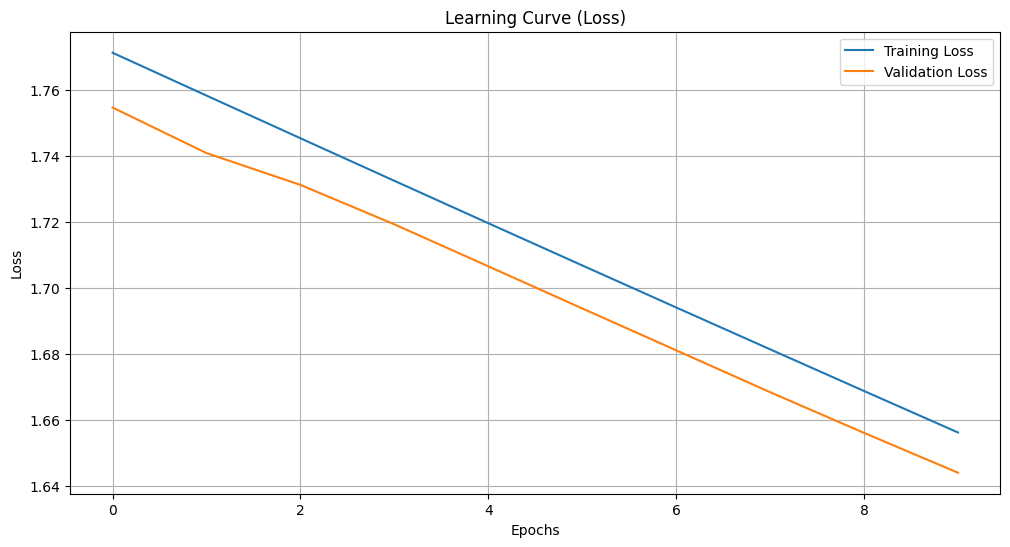

In [ ]:
# Call the function to plot learning curves after training
plot_learning_curve(history)

In [ ]:
# Function to preprocess a single image
def preprocess_image(image_path, resize_dim=(240, 290)):
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    # Resize the image
    img_resized = cv2.resize(img, resize_dim)

    # Normalize pixel values
    img_normalized = img_resized / 255.0

    # Add channel dimension
    img_input = img_normalized[..., np.newaxis]

    # Expand dimensions to make it batch-like (1, height, width, channels)
    return np.expand_dims(img_input, axis=0), img_resized

In [ ]:
# Function to test the model on a single image
def test_model_on_image(model, image_path, resize_dim=(240, 290), threshold=0.5):
    # Preprocess the image
    img_input, img_original = preprocess_image(image_path, resize_dim=resize_dim)

    # Predict the mask
    predicted_mask = model.predict(img_input)

    # Remove batch dimension
    predicted_mask = predicted_mask.squeeze()

    # Apply threshold to get binary mask
    binary_mask = (predicted_mask > threshold).astype(np.uint8)

    return img_original, predicted_mask, binary_mask

In [ ]:
# Visualize the results
def visualize_test_results(image_path, model, resize_dim=(240, 290), threshold=0.5):
    img_original, predicted_mask, binary_mask = test_model_on_image(
        model, image_path, resize_dim=resize_dim, threshold=threshold
    )

    plt.figure(figsize=(12, 4))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(img_original, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Predicted mask
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask (Raw)')
    plt.axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


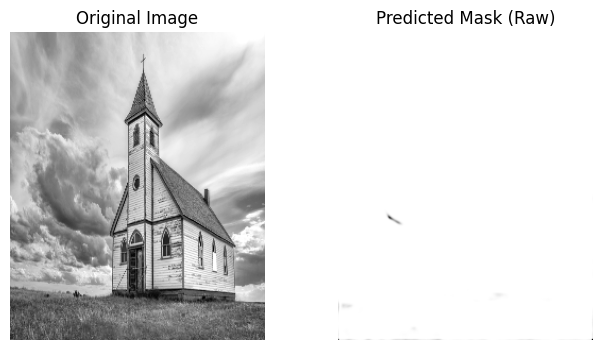

In [ ]:
test_image_path = '/content/church.jpg'
visualize_test_results(test_image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


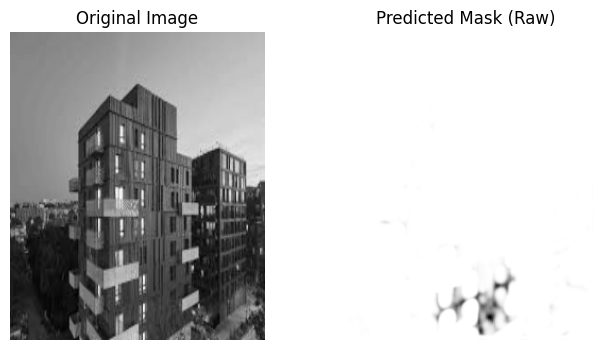

In [ ]:
est_image_path = '/content/skyscrapper.jpg'  # Replace with your image path
visualize_test_results(est_image_path, model)